In [21]:
# Imports

%matplotlib inline
from sklearn import mixture
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import *
import math
import random
from scipy.stats import pearsonr
import sys
from joblib import Parallel, delayed
import multiprocessing
nproc = max(1, multiprocessing.cpu_count() - 1)
from functools import partial

from sklearn import linear_model
from sklearn import ensemble
from scipy.spatial import distance
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.grid_search import GridSearchCV

if 'utils' not in sys.path:
    sys.path.append('utils')

import data_loader

# Warnings

import warnings
warnings.filterwarnings('ignore')

# Idempotent, cached data retrieval script

print(data_loader.load_chromosome.__doc__)
train_df, test_df, train_ix, test_ix, train_tissues, tfs = \
    data_loader.load_chromosome_cached('1')

Idempotent data loading. For a given chromosome n (a string).
    
    Returns (train_df, test_df, train_ix, test_ix, train_tissues, tfs)
    
    The first two are the train and test dataframes, and test_ix are the
    values in test_df['assayed'] that are missing and need to be imputed (with the
    correct answer being in test_df['filled'] in the corresponding locations.
    train_ix are the assayed (known) methylation values from limited microarray
    sampling (e.g., test_df['assayed'].iloc[train_ix] can be used for prediction of
    test_df['filled'].iloc[test_ix], and the former should be about equal to
    test_df['filled'].iloc[train_ix] (two different ways of sampling methylation).
    
    Imports genetic context and adds those columns to the parameter df, returning
    a merged one. tfs is the list of names of new transcription
    factors.
    
    train_tissues is a list of the names of columns with chromosome methylation values.
    
    Note that loading from scratch ma

In [2]:
# Double check that there actually are transcription factors in there:
train_df[list(tfs)].sum().sum()

413436

In [5]:
print('Num train tissues', len(train_tissues))
print('Num trans factors', len(tfs))

display_cols = list(train_df.columns)[:]
for i in train_tissues[2:] + tfs[2:]:
    display_cols.remove(i)
print('Dropping all but first two tissues, transcription factors.')
train_df.loc[range(267, 273)][display_cols]

Num train tissues 34
Num trans factors 161
Dropping all but first two tissues, transcription factors.


,chromosome,start,end,strand,b0,b1,GABPA,ZBTB33
267,chr1,121511,121513,True,0.714286,0.739130,False,False
268,chr1,121516,121518,True,0.857143,0.800000,False,False
269,chr1,122736,122738,False,0.545455,0.384615,False,False
270,chr1,122869,122871,False,0.837838,0.814815,False,False
271,chr1,122884,122886,False,0.842105,0.821429,False,False
272,chr1,127749,127751,True,0.633333,0.473684,False,False


In [6]:
assert len(train_df) == len(test_df)
def count_unique(col):
    return {x:sum(col == x) for x in set(col)}

print('Chromosome 1')
print('Total samples', len(train_df))
print('Site lengths', count_unique(train_df['end'] - train_df['start']))
print('Strand types', count_unique(train_df['strand']))
print('Known (test) sample site counts', len(train_ix))
print('Unknown (test) sample site counts', len(test_ix))
print('NaN ratio in all train samples',
      sum(sum(np.isnan(train_df[train_tissues].values))) / (len(train_df) * len(train_tissues)))
print('NaN ratio in test', sum(np.isnan(test_df['missing'])) / len(test_df))
assert sum(test_df['strand'] != train_df['strand']) == 0

Chromosome 1
Total samples 379551
Site lengths {2: 379551}
Strand types {False: 1464, True: 378087}
Known (test) sample site counts 7523
Unknown (test) sample site counts 368411
NaN ratio in all train samples 0.0849950103582
NaN ratio in test 0.980179211753


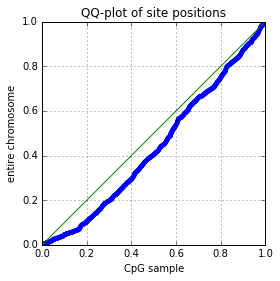

avg length between known sites 50.2903483116
sd of number of bp between sites 86.9614546017


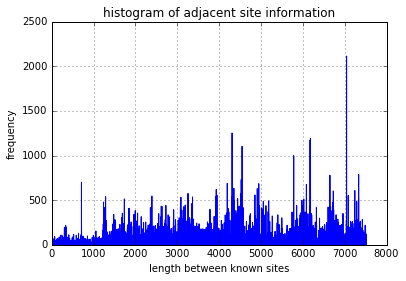

In [9]:
# Make sure our samples are pretty uniform from the genomic range
def ticks(n): return np.arange(0.0, n) / n
plt.plot(ticks(len(train_ix)), train_ix / len(train_df), '.')
plt.plot([0, 1])
plt.axes().set_aspect('equal')
plt.xlabel('CpG sample')
plt.ylabel('entire chromosome')
plt.title('QQ-plot of site positions')
plt.grid(True)
plt.show()

diffs = np.diff(train_ix)
print('avg length between known sites', np.mean(diffs))
print('sd of number of bp between sites', np.std(diffs))
plt.plot(np.diff(train_ix))
plt.xlabel('length between known sites')
plt.ylabel('frequency')
plt.title('histogram of adjacent site information')
plt.grid(True)
plt.show()

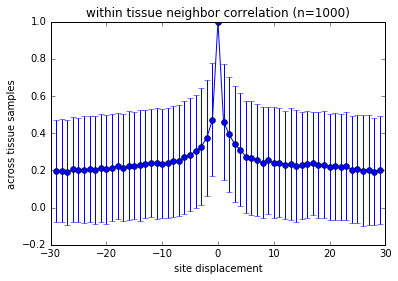

In [15]:
# Observe nearby site correlations
#TODO(vlad17): better sampling technique

def correlation(x, y):
    ix = np.where(~np.isnan(x) & ~np.isnan(y))
    return pearsonr(x[ix], y[ix])[0]

# Choose a random site, check neighbors within vicinity of 'reach'
reach = list(range(30))
reach = [-x for x in reversed(reach)] + reach[1:]
def sample_corr(reach):
    site = random.randint(max(reach), len(train_df) - max(reach) - 1)
    y = np.array(train_df.iloc[site][train_tissues[:-1]]
                 .values).astype(np.float64)
    nbrs = [site + i for i in reach]
    xs = np.array(train_df.iloc[nbrs][train_tissues[:-1]]
                  .values).astype(np.float64)
    return np.array([correlation(x, y) for x in xs])

sample = 1000
test = np.array([sample_corr(reach) for i in range(sample)])
plt.errorbar(reach, np.mean(test, axis=0), fmt='-o', yerr=np.std(test, axis=0))
plt.title('within tissue neighbor correlation (n={})'.format(sample))
plt.ylabel('across tissue samples')
plt.xlabel('site displacement')
plt.show()

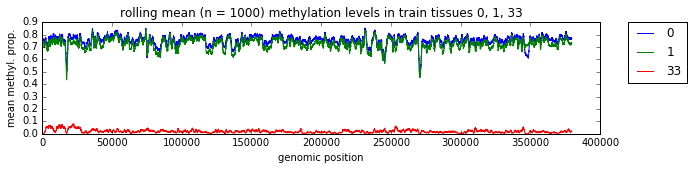

orig : rolling mean stddevs [4.8590050282935104, 4.6245001454552384, 11.339790875795508]


In [29]:
# Perhaps there are obvious sequence trends?
def local_impute(data):
    #http://stackoverflow.com/questions/9537543/replace-nans-in-numpy-array-with-closest-non-nan-value
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    return data

plt.figure(figsize=(10, 2))
ratios = []
plt.title('rolling mean (n = 1000) methylation levels in train tissues 0, 1, 33')
plt.xlabel('genomic position')
plt.ylabel('mean methyl. prop.')

x = local_impute(np.copy(train_df['b0']))
rolled = pd.Series(x).rolling(window=1000, win_type='boxcar').mean()
ratios.append(np.std(x) / np.std(rolled))
l0, = plt.plot(rolled, label='0')

x = local_impute(np.copy(train_df['b1']))
rolled = pd.Series(x).rolling(window=1000, win_type='boxcar').mean()
ratios.append(np.std(x) / np.std(rolled))
l1, = plt.plot(rolled, label='1')

x = local_impute(np.copy(train_df['b33']))
rolled = pd.Series(x).rolling(window=1000, win_type='boxcar').mean()
ratios.append(np.std(x) / np.std(rolled))
l33, = plt.plot(rolled, label='33')

plt.legend(handles=[l0, l1, l33])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
print('orig : rolling mean stddevs', ratios)

In [17]:
# Sparsity
print('Training tissue sparsities', [(train_df[i] <= 0.01).sum() / len(train_df) for i in train_tissues])
print('Sample sparsity', (test_df['filled'][train_ix] <= 0.01).sum() / len(train_ix))

Training tissue sparsities [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.97994999354500445]
Sample sparsity 0.0


In [30]:
# Do mean imputation on our training data.
def mean_impute(data):
    mask = np.isnan(data)
    data[mask] = float(data.mean()) # just = m messes with serialization
    return data
train_df_imp = train_df
train_df_int = train_df
for i in train_tissues:
    train_df_imp[i] = mean_impute(train_df[i].copy())
    train_df_int[i] = local_impute(train_df[i].copy())
print('nans in mean-imputed', np.isnan(train_df_imp[train_tissues]).sum().sum())
print('nans in interpolated', np.isnan(train_df_int[train_tissues]).sum().sum())

nans in mean-imputed 0
nans in interpolated 0


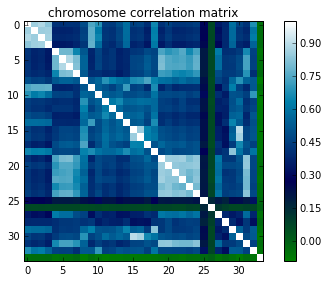

closest to test sample based on training data: 19


In [20]:
corr_mat = [[pearsonr(train_df_imp[a], train_df_imp[b])[0]
             for a in train_tissues] for b in train_tissues]
plt.imshow(corr_mat, interpolation='nearest', cmap=plt.cm.ocean)
plt.title('chromosome correlation matrix')
plt.colorbar()
plt.tight_layout()
plt.show()

def pandas_rmse(a, b):
    # http://stackoverflow.com/questions/27783494/root-mean-square-error-of-two-pandas-series
    return math.sqrt(a.sub(b).pow(2).mean())

l = [pandas_rmse(train_df_imp[t].iloc[train_ix], test_df['filled'][train_ix]) for t in train_tissues]
print('closest to test sample based on training data:', l.index(min(l)))

In [ ]:
#TODO(vlad17): testing code should be in a diff notebook.

In [40]:
# We'll only test on the well-behaved chromosomes similar to our
# test chromosome according to the cluster above, testable:
testable_tissues = ['b' + str(i) for i in range(19, 25)]
closest = 'b19'
# this is just an eyeball selection, but should prove good enough to
# offer decent generalization via cross validation.

In [13]:
# Define some evaluation functions

def denanify(a, b):
    mask = ~np.isnan(a) & ~np.isnan(b)
    assert mask.sum() > 0
    return a[mask], b[mask]

def correct_half(a, b):
    methylated_guess = a >= 0.5
    methylated_exact = b >= 0.5
    return (methylated_guess == methylated_exact).sum() / len(methylated_guess)

# Function f should return its estimate for the value in 'test_tissue'
# at each test_ix location. It gets its own copy of test_tissue, but
# train_cols is shared.
def eval_fold(f, train_cols, test_tissue, train_tissue_names):
    nanned = test_tissue.copy()
    nanned[test_ix] = np.nan
    guess = f(train_cols, nanned, train_tissue_names)
    assert sum(np.isnan(guess)) == 0
    # test_ix doesn't have nans in the test_df['filled'] col, but
    # within train_df there might be nans here.
    exact = test_tissue[test_ix]
    if not isinstance(guess, pd.Series):
        guess = pd.Series(guess, index=exact.index)
    assert len(guess) == len(exact)
    guess, exact = denanify(guess, exact)
    return np.array([pandas_rmse(guess, exact), correct_half(guess, exact),
                     r2_score(exact, guess)])

# Excludes the sparse chromosome from testing.
def cv_folds(f, df=train_df, threading='multiprocessing',
             additional_cols=[], test_tissues=testable_tissues):
    rmse_acc = np.zeros(3)
    ctr = 0
    arguments = []
    for t in test_tissues:
        train_cols = train_tissues[:]
        train_cols.remove(t)
        arguments.append((f, df[train_cols + additional_cols], df[t], train_cols))
    folds = [eval_fold(*i) for i in arguments] if not threading else \
            Parallel(n_jobs=min(nproc, len(arguments)), backend=threading) \
                (delayed(eval_fold)(*i) for i in arguments)
    return sum(folds) / len(folds)

def perfstr(rmse_acc):
    return 'rmse {} methylated acc {} R^2 {}'.format(*rmse_acc)

In [14]:
# No trends.
# Let's try imputing from but clearly we can impute from local neighbor data.
# Try using no information for our test chromosome as a baseline.

# Two simple approaches, with no information from other samples

def interpolation(cols, partial, train_tissue_names):
    return local_impute(partial).iloc[test_ix]
print('interpolation', perfstr(cv_folds(interpolation)))

def same_sample_mean(cols, partial, train_tissue_names):
    return mean_impute(partial).iloc[test_ix]
print('same tissue mean', perfstr(cv_folds(same_sample_mean)))

interpolation rmse 0.20477740780970047 methylated acc 0.8897997073920161 R^2 -0.6131129817291857
same tissue mean rmse 0.16247889234653728 methylated acc 0.9376303458184835 R^2 -0.015392692439529601


In [15]:
# As a dual approach, we can try using only information from the remaining tissues
# For example, we might try to take a mean of methylation values along the same site
def diff_sample_mean(cols, partial, train_tissue_names):
    return cols[train_tissue_names].iloc[test_ix].mean(axis=1)
print('diff tissue mean', perfstr(cv_folds(diff_sample_mean)))

diff tissue mean rmse 0.1318694424931256 methylated acc 0.9536961889483936 R^2 0.3256145169853153


In [16]:
def nearest_neighbor(cols, partial, train_tissue_names):
    nbr = min((pandas_rmse(cols[t].iloc[train_ix], partial.iloc[train_ix]), t)
              for t in train_tissue_names)[1]
    return cols[nbr].iloc[test_ix]
print('1NN', perfstr(cv_folds(nearest_neighbor, df=train_df_imp)))

1NN rmse 0.09120396089592973 methylated acc 0.968845483260091 R^2 0.6777635739603453


In [18]:
# Use the well-formedness of the other-tissue data to train a basic lm
def sklearn_model(lm, cols, partial, train_tissue_names):
    lm.fit(cols.iloc[train_ix], partial.iloc[train_ix])
    return lm.predict(cols.iloc[test_ix])

def log_range(lo, hi): return [10 ** i for i in range(lo, hi)]

def sklearn_model_only_metadata(lm, cols, partial, train_tissue_names):
    f = list(set(cols.columns) - set(train_tissue_names))
    lm.fit(cols[f].iloc[train_ix], partial.iloc[train_ix])
    return lm.predict(cols[f].iloc[test_ix])

lmmodels = [
    ('OLS', linear_model.LinearRegression()),
    ('Ridge', linear_model.RidgeCV(alphas=log_range(-1, 4), cv=8)),
    ('Lasso', linear_model.LassoCV(alphas=log_range(-6,-1), cv=8)),
    ('RFR', ensemble.RandomForestRegressor(n_estimators=100)),
    ('ElasticNet', linear_model.ElasticNetCV(l1_ratio=np.arange(.1, 1, .1), cv=8)),
    #('ARDRegression', linear_model.ARDRegression())
]

df = train_df_int
#df = train_df_imp

def run_models(cv_fun):
    best = None, [None, None, -np.inf], None
    for name, model in lmmodels:
        perf = cv_fun(model)
        if perf[2] > best[1][2]: best = name, perf
        print('\t{: <16} rmse {:04f} methyl acc {:04f} R^2 {:04f}'.format(name, *perf))
    print('\tBEST', best[0], ' (R^2 = {})'.format(best[1][2]))

print('only tissue data')
run_models(lambda model: cv_folds(partial(sklearn_model, model), df=df))

print('only metadata')
metadata_names = list(tfs) + ['strand']
run_models(lambda model: cv_folds(partial(sklearn_model_only_metadata, model),
                                  df=df, additional_cols=metadata_names))

for t in train_tissues:
    df[t + 'prev'] = df[t].shift(-1)
    df[t + 'prev'].iloc[len(df)-1] = df[t][len(df)-1]
    df[t + 'next'] = df[t].shift(1)
    df[t + 'next'].iloc[0] = df[t][0]

print('only neighbors')
nbrs_names = [x + 'prev' for x in train_tissues] + [x + 'next' for x in train_tissues]
run_models(lambda model: cv_folds(partial(sklearn_model_only_metadata, model),
                                  df=df, additional_cols=nbrs_names))

only tissue data
	OLS              rmse 0.069186 methyl acc 0.976359 R^2 0.813765
	Ridge            rmse 0.069097 methyl acc 0.976369 R^2 0.814253
	Lasso            rmse 0.069076 methyl acc 0.976358 R^2 0.814326
	RFR              rmse 0.069235 methyl acc 0.975851 R^2 0.813399
	ElasticNet       rmse 0.069056 methyl acc 0.976347 R^2 0.814434
	BEST ElasticNet  (R^2 = 0.8144342091337995)
only metadata
	OLS              rmse 42472398862.237488 methyl acc 0.937207 R^2 -75892152557656353013760.000000
	Ridge            rmse 0.154997 methyl acc 0.938248 R^2 0.075668
	Lasso            rmse 0.154597 methyl acc 0.938605 R^2 0.080309
	RFR              rmse 0.156734 methyl acc 0.936109 R^2 0.054276
	ElasticNet       rmse 0.154603 methyl acc 0.938572 R^2 0.080293
	BEST Lasso  (R^2 = 0.08030944044610151)
only neighbors
	OLS              rmse 0.120703 methyl acc 0.953302 R^2 0.437951
	Ridge            rmse 0.120465 methyl acc 0.953381 R^2 0.440225
	Lasso            rmse 0.120336 methyl acc 0.953469 R^2

In [19]:
def membased_cf(simil, cols, partial, train_tissue_names):
    # https://en.wikipedia.org/wiki/Collaborative_filtering
    similarities = np.array([simil(cols[t].iloc[train_ix],
                                   partial.iloc[train_ix])
                             for t in train_tissue_names])
    k = np.sum(np.fabs(similarities))
    others = cols[train_tissue_names].iloc[test_ix].values
    return others.dot(similarities) / k

def cosine_similarity(x, y): return 1 - distance.cosine(x, y)
def canberra_similarity(x, y): return len(x) - distance.canberra(x, y)
def correlation_similarity(x, y):
    c = distance.correlation(x, y)
    if np.isnan(c): return 0
    else: return 1 - c

models = [
    ('cosine', cosine_similarity),
    ('canberra', canberra_similarity),
    ('correlation', correlation_similarity)
]
print('memory-based aggr CF over different similarities')
for name, dist in models:
    print(name, perfstr(cv_folds(partial(membased_cf, dist), df=train_df_imp)))

# TODO: utilize local values somehow: expand features to neighbors somehow?
# TODO: regularized SVD-based CF (need to homebrew with tensorflow)
# https://github.com/vlad17/TensorFlow-Learn/blob/master/notebooks/mnist.ipynb for svd, above
# TODO: GMM on full tissue samples, then do a marginalized posterior from the limited new
# sample data (also needs a homebrew EM). Would use a diagonal, +1, -1 band covar matrix and EM algo.
# TODO polynomial multiplication with indicators on the feature set.

memory-based aggr CF over different similarities
cosine rmse 0.13076129635912162 methylated acc 0.9544960202961729 R^2 0.3368235828848261
canberra rmse 0.12854128714662824 methylated acc 0.9556251939636257 R^2 0.3591848371114346
correlation rmse 0.10269469361348192 methylated acc 0.9639252537700195 R^2 0.5919495306590167


In [42]:
useful_cols = list(df.columns)
useful_cols.remove('chromosome')
useful_cols.remove('start')
useful_cols.remove('end')

# Let's take a closer look at lm perf for one of our folds.
train_cols_fold1 = useful_cols[:]
train_cols_fold1.remove(closest)

test_col_fold1 = closest
train_tissues_fold1 = train_tissues[:]
train_tissues_fold1.remove(closest)

lmd = dict(lmmodels)

guess_tissue = sklearn_model(lmd['ElasticNet'], df[train_tissues_fold1],
                             df[test_col_fold1], [])
guess_metadata = sklearn_model(lmd['Lasso'], df[metadata_names],
                               df[test_col_fold1], [])
guess_cf = membased_cf(correlation_similarity, df[train_tissues_fold1],
                       df[test_col_fold1], train_tissues_fold1)
guess_nbrs = sklearn_model(lmd['ElasticNet'], df[nbrs_names],
                           df[test_col_fold1], [])

exact = train_df_imp[closest].iloc[test_ix]

def print_instance_evaluation(name, guess):
    rmse = math.sqrt(mean_squared_error(exact, guess))
    acc = correct_half(exact, guess)
    r2 = r2_score(exact, guess)
    print('{: <16} rmse {:04f} methyl acc {:04f} R^2 {:04f}'
          .format(name, rmse, acc, r2))
print('rmse lm(metadata)', math.sqrt(mean_squared_error(exact, guess_metadata)))
print('rmse lm(tissue)', math.sqrt(mean_squared_error(exact, guess_tissue)))
print('rmse lm(nbrs)', math.sqrt(mean_squared_error(exact, guess_nbrs)))
print('rmse cf', math.sqrt(mean_squared_error(exact, guess_cf)))

rmse lm(metadata) 0.15914248602399436
rmse lm(tissue) 0.0615562563736748
rmse lm(nbrs) 0.11946044593081
rmse cf 0.10307612585646515


In [74]:
res_tissue = guess_tissue - exact
res_metadata = guess_metadata - exact
res_cf = guess_cf - exact
res_nbr = guess_nbrs - exact

residuals = [res_tissue, res_metadata, res_cf, res_nbr]
names = ['tissue', 'metadata', 'CF', 'neighbors']
tbl = [((ni, nj), scipy.stats.pearsonr(i, j)[0]) for (ni, i), (nj, j) in combinations(zip(names, residuals), 2)]
(names, corr) = zip(*tbl)
print('max corr', max(tbl, key=(lambda x: x[1])))
print('avg corr', sum(corr) / len(corr))

max corr (('tissue', 'CF'), 0.6672206595636575)
avg corr 0.543763026004


In [44]:
def ensemble_regression(lm, cols, partial, train_tissue_names):
    simil = correlation_similarity
    similarities = np.array([simil(cols[t].iloc[train_ix],
                                   partial.iloc[train_ix])
                             for t in train_tissue_names])
    k = np.sum(np.fabs(similarities))
    others = cols[train_tissue_names].values
    cf = pd.Series(others.dot(similarities) / k, index=cols.index)
    cols = cols.copy(deep=False)
    cols['cf'] = cf
    return sklearn_model(lm, cols, partial, train_tissue_names)
print('tissue + metadata + CF + nbrs')
run_models(lambda model: cv_folds(partial(ensemble_regression, model),
                                  df=df, additional_cols=(metadata_names + nbrs_names)))
print('tissue + metadata + CF')
run_models(lambda model: cv_folds(partial(ensemble_regression, model),
                                  df=df, additional_cols=metadata_names))
print('tissue + nbrs + CF')
run_models(lambda model: cv_folds(partial(ensemble_regression, model),
                                  df=df, additional_cols=nbrs_names))
print('tissue + CF')
run_models(lambda model: cv_folds(partial(ensemble_regression, model),
                                  df=df))
print('tissue + nbrs')
run_models(lambda model: cv_folds(partial(ensemble_regression, model),
                                  df=df, additional_cols=nbrs_names))
print('tissue + metadata')
run_models(lambda model: cv_folds(partial(sklearn_model, model),
                                  df=df, additional_cols=metadata_names))

tissue + metadata + CF + nbrs
	OLS              rmse 918294465407.820923 methyl acc 0.505070 R^2 -46089434015125237978365952.000000
	Ridge            rmse 0.065632 methyl acc 0.978640 R^2 0.831743
	Lasso            rmse 0.065382 methyl acc 0.978741 R^2 0.832932
	RFR              rmse 0.067801 methyl acc 0.976716 R^2 0.820712
	ElasticNet       rmse 0.065386 methyl acc 0.978702 R^2 0.832885
	BEST Lasso  (R^2 = 0.8329319767440063)
tissue + metadata + CF
	OLS              rmse 0.069344 methyl acc 0.976391 R^2 0.812837
	Ridge            rmse 0.068907 methyl acc 0.976405 R^2 0.815195
	Lasso            rmse 0.068943 methyl acc 0.976432 R^2 0.815013
	RFR              rmse 0.069135 methyl acc 0.975969 R^2 0.813892
	ElasticNet       rmse 0.068888 methyl acc 0.976413 R^2 0.815304
	BEST ElasticNet  (R^2 = 0.8153037818902217)
tissue + metadata + CF
	OLS              rmse 0.065802 methyl acc 0.978831 R^2 0.830862
	Ridge            rmse 0.065698 methyl acc 0.978804 R^2 0.831421
	Lasso            rmse

In [49]:
# Having chosen our best model, organize a true training and test set
# for our holdout tissue
similarities = np.array([correlation_similarity(df[t].iloc[train_ix],
                                                test_df['filled'].iloc[train_ix])
                         for t in train_tissues])
k = np.sum(np.fabs(similarities))
cf = pd.Series(df[train_tissues].values.dot(similarities) / k, index=df.index)
df_with_cf = df[useful_cols]
df_with_cf['cf'] = cf

In [67]:
# Grid search narrowed down by re-running same training set
# (without looking at test accuracy)
best_combined = linear_model.Lasso()
grid = GridSearchCV(best_combined, {'alpha': np.arange(1e-4, 2e-4, 1e-6)}, cv=50, n_jobs=nproc)
grid.fit(df_with_cf.iloc[train_ix], test_df['filled'].iloc[train_ix])
grid.best_params_

{'alpha': 0.00015999999999999982}

In [68]:
guess = grid.predict(df_with_cf.iloc[test_ix])
exact = test_df['filled'].iloc[test_ix].values

rmse = math.sqrt(mean_squared_error(exact, guess))
acc = correct_half(exact, guess)
r2 = r2_score(exact, guess)
res = guess - exact

print('Ensemble on test: rmse {:04f} methyl acc {:04f} R^2 {:04f}'.format(rmse, acc, r2))

Ensemble on test: rmse 0.059271 methyl acc 0.980633 R^2 0.877143


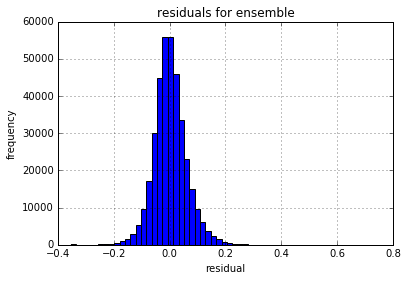

sd ratios [4.6196193481454584, 4.1785891525192111]


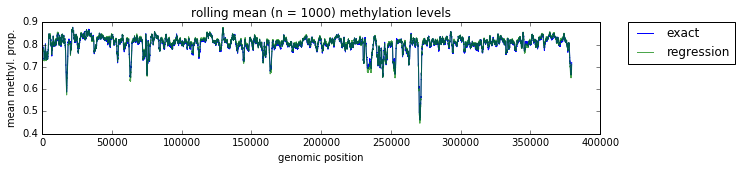

In [69]:
plt.hist(res, bins=50)
plt.xlabel('residual')
plt.ylabel('frequency')
plt.title('residuals for ensemble')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 2))
ratios = []
plt.title('rolling mean (n = 1000) methylation levels')
plt.xlabel('genomic position')
plt.ylabel('mean methyl. prop.')

ratios = []

x = local_impute(np.copy(test_df['filled']))
rolled = pd.Series(x).rolling(window=1000, win_type='boxcar').mean()
ratios.append(np.std(x) / np.std(rolled))
actual, = plt.plot(rolled, label='exact')

x = grid.predict(df_with_cf)
rolled = pd.Series(x).rolling(window=1000, win_type='boxcar').mean()
ratios.append(np.std(x) / np.std(rolled))
guess, = plt.plot(rolled, label='regression', alpha=0.7)

print('sd ratios', ratios)
plt.legend(handles=[actual,guess])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [71]:
np.isnan(test_df['filled']).mean(), 4.6196193481454584 ** 2

(0.0095296811232219118, 21.34088292175987)

 regularized iterative SVD: for every present user U and some number of factors (dim V)
 $\min \sum_{i,j \in R} (r_{i,j} - \mathbf{U}_i \  \mathbf{V}_j^T) +  \lambda (\sum_i \lVert \mathbf{U}_i \rVert^2   \sum_j \lVert \mathbf{V}_j \rVert^2)$

In [80]:
# See how the other chromosomes did (results from running and saving script
# check_chromosome.py)
# Note R^2 for chr1 is different because of random initialization.
del i
! for i in chr*.txt; do echo $i $(tail -1 $i); done

chr11.txt Ensemble on test: rmse 0.058498 methyl acc 0.980540 R^2 0.881261 alpha 0.000187
chr1.txt Ensemble on test: rmse 0.059487 methyl acc 0.980514 R^2 0.876247 alpha 0.000186
chr2.txt Ensemble on test: rmse 0.058964 methyl acc 0.981492 R^2 0.871433 alpha 0.000192
chr6.txt Ensemble on test: rmse 0.058874 methyl acc 0.981250 R^2 0.874899 alpha 0.000198
chr7.txt Ensemble on test: rmse 0.059009 methyl acc 0.980331 R^2 0.870044 alpha 0.000169


## GMM on methylation values

In [36]:
# Try running GMM on first hundred methylation values for each sample
# print(train_df)

# print(train_df_imp)
train_methyls = train_df_imp[train_tissues].values
print(len(train_methyls))

train_methyls_T = train_methyls.T
print(len(train_methyls_T))

train_methyls_T_100 = train_methyls_T[:, :100]
print(train_methyls_T_100.shape)

gmm = mixture.GMM(n_components=5)
gmm.fit(train_methyls_T_100)

# print(gmm.means_)
# print(gmm.covars_)
print(gmm.weights_)
print(gmm.means_)


379551
34
(34, 100)
[ 0.05882353  0.02941176  0.32352941  0.41176471  0.17647059]
[[ 0.64772899  0.64772899  0.64772899  0.64772899  0.64772899  0.64772899
   0.64772899  0.64772899  0.64772899  0.64772899  0.64772899  0.64772899
   0.64772899  0.64772899  0.64772899  0.64772899  0.64772899  0.64772899
   0.64772899  0.64772899  0.64772899  0.64772899  0.38067491  0.64772899
   0.36257536  0.44660898  0.38067491  0.67875183  0.64772899  0.64772899
   0.5796139   0.63708518  0.57258065  0.55375183  0.62375183  0.58152963
   0.59786948  0.60375183  0.60809963  0.73232327  0.73232327  0.64772899
   0.75112023  0.71551653  0.64772899  0.64772899  0.64772899  0.76027358
   0.64772899  0.76027358  0.76671478  0.64772899  0.60375183  0.64857943
   0.64772899  0.45759799  0.44660898  0.4704185   0.72041848  0.6298388
   0.75091575  0.62193363  0.58333335  0.74819628  0.70375183  0.73708518
   0.64772899  0.64772899  0.74819628  0.63708518  0.73557003  0.6608947
   0.70851373  0.74125183  0.715